In [3]:
train_path = "./new_train/new_train"
test_path = "./new_val_in/new_val_in"
submission_path = "./sample_submission.csv"
submission_dir = "./submissions"

In [4]:
# Train Val Split
TRAIN_SIZE = 0.95
VAL_SIZE = 0.05

# training config
NUM_EPOCH = 20
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EARLY_STOP_MAX = 6

# feature engineering configs
NEARBY_DISTANCE_THRESHOLD = 50.0  # Distance threshold to call a track as neighbor
DEFAULT_MIN_DIST_FRONT_AND_BACK = 100. # default distance 

In [5]:
import os
import copy
import pickle
import numpy as np
from glob import glob
import pandas as pd
from tqdm import tqdm
from typing import Tuple
import matplotlib.pyplot as plt

from utils import plot_trajectory

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [6]:
%load_ext autoreload
%autoreload 2

from argoverse_forecasting.utils.social_features_utils import SocialFeaturesUtils
from argoverse_forecasting.utils import baseline_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data 

In [7]:
class ArgoverseDataset(Dataset):
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
        
        if self.transform:
            data = self.transform(data)

        return data

In [8]:
train = ArgoverseDataset(data_path=train_path)
test = ArgoverseDataset(data_path=test_path)

In [20]:
train_size = int(TRAIN_SIZE * len(train))
val_size = len(train) - train_size
train, val = torch.utils.data.random_split(train, [train_size, val_size])

## Preprocessing

In [10]:
def get_agent_track(scene, mode="train"):
    agent_idx = np.where(scene["agent_id"] == np.unique(scene["track_id"].flatten()))[0][0]
    agent_traj = scene['p_in'][agent_idx]
    if mode == "test":
        return agent_traj
    else:
        agent_traj = np.concatenate([agent_traj, scene['p_out'][agent_idx]])
    return agent_traj

def get_social_tracks(scene, mode="train"):
    agent_idx = np.where(scene["agent_id"] == np.unique(scene["track_id"].flatten()))[0][0]
    social_masks = scene["car_mask"].flatten()
    social_masks[agent_idx] = 0
    social_trajs = scene['p_in'][social_masks.astype(bool)]
    
    if mode == "test":
        return social_trajs
    else:
        return np.concatenate([social_trajs, scene['p_out'][social_masks.astype(bool)]], axis=1)

In [11]:
# generate social features
def get_social_features(scene, mode="train"):
    """
    Extract social features:
        1. number of neighbors
        2. min front/back distance at each timestamp
    """
    agent_track = get_agent_track(scene, mode)
    social_tracks = get_social_tracks(scene, mode)
    # compute social features
    num_neighbors = count_num_neighbors(agent_track[:19], social_tracks[:, :19])
    social_features_utils = SocialFeaturesUtils()
    min_dist_front_back = social_features_utils.get_min_distance_front_and_back(
        agent_track=agent_track,
        social_tracks=social_tracks,
        obs_len=19,
        raw_data_format={"X": 0, "Y": 1}
    )
    
    return np.concatenate((num_neighbors, min_dist_front_back), axis=1)
#     return num_neighbors

In [12]:
def count_num_neighbors(agent_traj, social_trajs):
    """
    Calculate euclidean distance between agent_traj and social_trajs
    if distance is less than NEARBY_DISTANCE_THRESHOLD, then num_neighbors++
    
    Args:
        agent_traj (np.array): data for agent trajectory
        social_trajs (np.array): array of other agents' trajectories
    Returns:
        (np.array): 
    """
    num_neighbors = []
    dist = np.sqrt(
        (social_trajs[:, :, 0] - agent_traj[:, 0])**2 
        + (social_trajs[:, :, 1] - agent_traj[:, 1])**2
    ).T
    num_neighbors = np.sum(dist < NEARBY_DISTANCE_THRESHOLD, axis=1)
    return num_neighbors.reshape(-1, 1)

In [30]:
def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp, out = [], []
    for scene in batch:
        agent_idx = np.where(scene["agent_id"] == np.unique(scene["track_id"].flatten()))[0][0]
        social_features = get_social_features(scene)
        inp.append(np.hstack([scene['p_in'][agent_idx], scene['v_in'][agent_idx], social_features]))
        out.append(scene['p_out'][agent_idx])

    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    return [inp, out]

def my_test_collect(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp, out = [], []
    for scene in batch:
        agent_idx = np.where(scene["agent_id"] == np.unique(scene["track_id"].flatten()))[0][0]
        social_features = get_social_features(scene, mode="test")
        inp.append(np.hstack([scene['p_in'][agent_idx], scene['v_in'][agent_idx], social_features])) #
        out.append([])

    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    return [inp, out]


train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle = True, collate_fn=my_collate, num_workers=0)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle = True, collate_fn=my_collate, num_workers=0)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle = False, collate_fn=my_test_collect, num_workers=0)
# exmaple = iter(train_loader)
# exmaple.next()[0][0]

In [40]:
submission = pd.read_csv(submission_path)
submission

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,9897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3196,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3197,9905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3198,9910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Social Features

In [26]:
social_features_utils = SocialFeaturesUtils()

In [27]:
train_0 = train[1]
agent_track = get_agent_track(train_0)
social_trajs = get_social_tracks(train_0)

In [28]:
# pd.DataFrame(social_trajs.reshape(49, -1))

In [29]:
social_features_utils.get_min_distance_front_and_back(
    agent_track=agent_track,
    social_tracks=social_trajs,
    obs_len=19,
    raw_data_format={"X": 0, "Y": 1}
)

array([[100.        ,  15.01957467],
       [100.        ,  15.03496758],
       [100.        ,  15.0876905 ],
       [100.        ,  15.14558106],
       [100.        ,  15.15392235],
       [100.        ,  15.24686276],
       [100.        ,  15.30731891],
       [100.        ,  15.38558173],
       [100.        ,  15.43085473],
       [100.        ,  15.50671457],
       [100.        ,  15.50534544],
       [100.        ,  15.63636553],
       [100.        ,  15.70307065],
       [100.        ,  15.81726693],
       [100.        ,  15.94335686],
       [100.        ,  16.16866568],
       [100.        ,  16.29137123],
       [100.        ,  16.34310798],
       [100.        ,  16.56050952]])

In [30]:
train_0 = train[8]
agent_track = get_agent_track(train_0)
social_trajs = get_social_tracks(train_0)
# train_1 = train[11]
# agent_track = get_agent_track(train_1)
# social_trajs = get_social_tracks(train_1)

In [31]:
normalized_traj, translation, rotation = baseline_utils.get_normalized_traj(
    np.concatenate([[agent_track], social_trajs]), None)

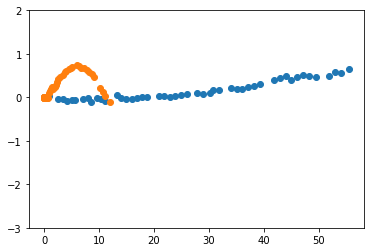

In [32]:
agent_id = 0
agent_id_2 = 4
plt.scatter(normalized_traj[agent_id][:, 0], normalized_traj[agent_id][:, 1])
plt.scatter(normalized_traj[agent_id_2][:, 0], normalized_traj[agent_id_2][:, 1])
plt.yticks(range(-3, 3))
plt.show()

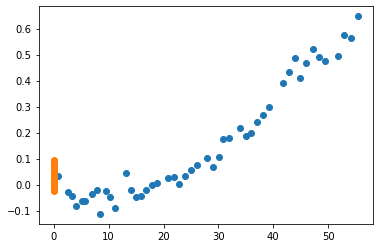

In [33]:
agent_id = 0
agent_id_2 = 2
plt.scatter(normalized_traj[agent_id][:, 0], normalized_traj[agent_id][:, 1])
plt.scatter(normalized_traj[agent_id_2][:, 0], normalized_traj[agent_id_2][:, 1])
# plt.yticks(range(-3, 3))
plt.show()

In [213]:
baseline_utils.normalized_to_map_coordinates(
    normalized_traj, translation, rotation
)[0]

array([[2207.51831055,  751.89544678],
       [2207.28613281,  751.90447998],
       [2206.83276367,  751.51550293],
       [2206.30200195,  751.29669189],
       [2205.66674805,  750.88928223],
       [2205.39404297,  750.80029297],
       [2204.80322266,  750.51055908],
       [2204.35107422,  750.26348877],
       [2204.14599609,  750.22930908],
       [2203.68139648,  750.07891846],
       [2203.26147461,  749.96154785],
       [2202.75488281,  749.86889648],
       [2202.22338867,  749.81280518],
       [2201.59130859,  749.76489258],
       [2201.2199707 ,  749.79815674],
       [2200.68725586,  749.82940674],
       [2200.16259766,  749.92297363],
       [2199.65893555,  749.9956665 ],
       [2199.13012695,  750.18768311],
       [2198.65014648,  750.33508301],
       [2198.15551758,  750.54882812],
       [2197.72875977,  750.77722168],
       [2197.16235352,  751.05474854],
       [2196.60522461,  751.31378174],
       [2196.14404297,  751.59326172],
       [2195.73193359,  7

In [34]:
def get_normalized_traj(coords: np.ndarray, mode: str="train"):
    """
    Normalize coordinates
    1) translation and rotation
    2) relative distance
    
    Args:
        coords (np.ndarray): (num_tracks x seq_len x 2) coordinates
        mode (str): train/val/test
    Returns:
        normalized_coords (np.ndarray): (num_tracks x seq_len x 2) normalized coordinates
        helpers (dict): a dictionary of helpers
    """
    norm_traj_arr, translation, rotation = baseline_utils.get_normalized_traj(coords, None)
#     norm_traj_arr, reference = baseline_utils.get_relative_distance(norm_traj_arr, mode)
    
    helpers = {
        "translation": translation,
        "rotation": rotation,
#         "reference": reference
    }
    return norm_traj_arr, helpers

In [35]:
def get_absolute_distance(inp: np.ndarray, out: np.ndarray, helpers: dict):
    obs_len, pred_len = len(inp), len(out)
    reference = helpers["reference"].copy()
    inp[:, 0, :2] = reference
    for i in range(1, obs_len):
        inp[:, i, :2] = inp[:, i, :2] + inp[:, i - 1, :2]

        out[:, 0, :2] = out[:, 0, :2] + inp[:, -1, :2]
    for i in range(1, pred_len):
        out[:, i, :2] = out[:, i, :2] + out[:, i - 1, :2]
    return inp, out

In [36]:
def get_denormalized_traj(inp: np.ndarray, out: np.ndarray, helpers: dict, mode: str="train"):
    """
    Denormalize coordinates
    1) get absolute distance
    2) inverse translation and rotation
    
    Args:
        inp (np.ndarray): (num_tracks x seq_len x 2) normalized input coords
        out (np.ndarray): (num_tracks x seq_len x 2) normalized output coords
        helpers (dict): a dictionary of helpers
        mode (str): train/val/test
    Returns:
        coords (np.ndarray): (num_tracks x seq_len x 2) coordinates
    """
    # Convert relative to absolute
#     inp, out = get_absolute_distance(inp, out, helpers)

    # Denormalize trajectory
    translation = helpers["translation"].copy()
    rotation = helpers["rotation"].copy()
    if inp is not None:
        inp[:, :, :2] = baseline_utils.normalized_to_map_coordinates(
            inp[:, :, :2], translation, rotation)

    if out is not None:
        out[:, :, :2] = baseline_utils.normalized_to_map_coordinates(
            out[:, :, :2], translation, rotation)
    return inp, out


In [37]:
normalized_traj, helpers = get_normalized_traj(social_trajs)

In [38]:
traj = get_denormalized_traj(normalized_traj[:, :19, :], normalized_traj[:, 19:, :], helpers)

# Data preprocessing

In [39]:
def get_relative_position(inp, out=None):
    """calculate position difference"""
    input_length = inp.shape[1]
    p_in_0 = copy.deepcopy(inp[:, 0, :2])
    
    
    if out is not None:
        out = copy.deepcopy(out)
        output_length = out.shape[1]
        for i in range(output_length - 1, 0, -1):
            out[:, i, :2] = out[:, i, :2] - out[:, i - 1, :2]
        out[:, 0, :2] = out[:, 0, :2] - inp[:, -1, :2]
        
    for i in range(input_length - 1, 0, -1):
        inp[:, i, :2] = inp[:, i, :2] - inp[:, i - 1, :2]
    inp[:, 0, :] = 0
    
    if out is not None:
        return inp, out, p_in_0
    
    return inp, p_in_0

In [40]:
def get_absolute_position(inp, out, p_in_0, return_pred_only=False):
    """position inverse difference"""
    inp[:, 0, :2] = p_in_0
    for i in range(1, inp.shape[1]):
        inp[:, i, :2] = inp[:, i, :2] + inp[:, i - 1, :2]

    out[:, 0, :2] = out[:, 0, :2] + inp[:, -1, :2]
    for i in range(1, out.shape[1]):
        out[:, i, :2] = out[:, i, :2] + out[:, i - 1, :2]
    
    if return_pred_only:
        return out
    
    return inp, out

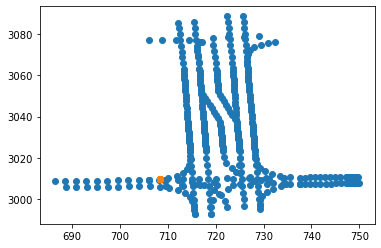

In [49]:
train_sample = train[8]
agent_id = 2
plt.scatter(train_sample['lane'][:, 0], train_sample['lane'][:, 1])
plt.scatter(train_sample['p_in'][agent_id][:, 0], train_sample['p_in'][agent_id][:, 1])
plt.scatter(train_sample['p_out'][agent_id][:, 0], train_sample['p_out'][agent_id][:, 1])

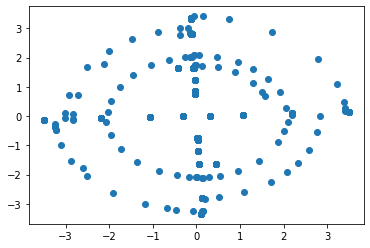

In [42]:
plt.scatter(train_sample['lane_norm'][:, 0], train_sample['lane_norm'][:, 1])

## Map features

# Training

In [22]:
# model training
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [23]:
class RMSELoss(torch.nn.Module):
    """RMSE Loss"""
    def __init__(self):
        super(RMSELoss, self).__init__()

    def forward(self, yhat, y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(yhat, y))
        return loss

## Seq2Seq (LSTM)

In [24]:
# training config
ROLLOUT_LEN = 30

# model config
INPUT_SIZE = 5

In [26]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=30*2):
        super(MLP, self).__init__()

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size * 19, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, X):        
        out = self.mlp(X)
        return out

In [121]:
def check_validation(val_loader, model, normalize=False):
    loss_fn = RMSELoss()
    
    for i_batch, batch_data in enumerate(val_loader):
        inp, out = batch_data
        inp = inp.to(device)
        out = out.to(device)
        
        # eval mode
        model.eval()

        # Get relative position
        initial_p_in = inp[:, 0, :2].detach().clone()
        inp[:, :, :2] = inp[:, :, :2] - initial_p_in[:, None]
        out[:, :, :2] = out[:, :, :2] - initial_p_in[:, None]

        # model training
        pred_out = model(inp)

        # calculate loss 
        loss = loss_fn(pred_out, out.flatten(start_dim=1))

    return loss

In [32]:
# model training
model = MLP(7)
model.to(device)

loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [33]:
# training
train_losses = []
val_losses = []
prev_loss, non_decreasing_loss_cnt = -float("inf"), 0
for epoch in range(NUM_EPOCH):
    train_iterator = tqdm(train_loader, total=int(len(train_loader)))
    total = 0
    count = 0
    for i_batch, batch_data in enumerate(train_iterator):
        inp, out = batch_data
        inp = inp.to(device)
        out = out.to(device)

        # Set to train mode
        model.train()

        # Get relative position  
        initial_p_in = inp[:, 0, :2].detach().clone()
        inp[:, :, :2] = inp[:, :, :2] - initial_p_in[:, None]
        out[:, :, :2] = out[:, :, :2] - initial_p_in[:, None]
        
        # model training
        pred_out = model(inp)

        # Get average loss for pred_len
        loss = loss_fn(pred_out, out.flatten(start_dim=1))
#         pred_out = decoder_outputs[:, :, :2].detach().cpu().numpy() + initial_p_in[:, None].detach().cpu().numpy()

        # Backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print loss
        total += loss.item()
        count += 1
        train_iterator.set_postfix_str("loss={}, avg.={}".format(loss.item(), total/count))
            
        if i_batch % 400 == 0:
            # print training loss
            training_loss = loss.item()
            train_losses.append(training_loss)
        
            # validate 
#             with torch.no_grad():
#                 val_loss = check_validation(val_loader, encoder, decoder, normalize=False)
#                 val_losses.append(val_loss.item())  
            
#             print(f"Epoch {epoch+1}/{NUM_EPOCH}, batch {i_batch}/{len(train_loader)}, "\
#                     + f"Training loss: {training_loss:.4f}")#\
                    #  + f", Val loss: {val_loss.item():.4f}")

 27%|██▋       | 777/2905 [12:42<34:49,  1.02it/s, loss=2.3595283031463623, avg.=2.5490653359905324] 


KeyboardInterrupt: 

In [35]:
torch.save(model.state_dict(), "./models/mlp+social(7).pth")

In [36]:
# predict
pred_p_out = []
all_zeros_ix = []
real_inp = None
with torch.no_grad():
    for i_batch, batch_data in enumerate(test_loader):
        inp, out = batch_data
        inp = inp.to(device)
                    
        # Set to eval mode
        model.eval()

        # Encoder
        batch_size = inp.shape[0]
        input_length = inp.shape[1]
        input_shape = inp.shape[2]

        # Get relative position
        initial_p_in = inp[:, 0, :2].detach().clone()
        real_inp = inp.detach().clone()
        inp[:, :, :2] = inp[:, :, :2] - initial_p_in[:, None]
#         inp, p_in_0 = get_relative_position(inp)
        
        # Encode observed trajectory
        pred_out = model(inp)
        pred_out = pred_out.view(batch_size, 30, -1)
        pred_out = pred_out.detach().cpu() + initial_p_in[:, None].detach().cpu()
            
        # predicted_p_out
#         out = get_absolute_position(inp, decoder_outputs.to(device), p_in_0, return_pred_only=True)
        pred_p_out.append(pred_out)

In [37]:
predicted_p_out = torch.FloatTensor(len(val_loader), 30, 2)#.to(device)
torch.cat(pred_p_out, out=predicted_p_out)

tensor([[[1714.4481,  336.7177],
         [1715.4248,  337.6729],
         [1716.3326,  338.5103],
         ...,
         [1739.7549,  360.2326],
         [1740.6722,  361.1239],
         [1741.5356,  361.9096]],

        [[ 725.0208, 1230.1365],
         [ 724.9872, 1229.9023],
         [ 724.8836, 1229.6140],
         ...,
         [ 722.5894, 1223.3909],
         [ 722.5499, 1223.1188],
         [ 722.4720, 1222.8254]],

        [[ 574.4733, 1245.3297],
         [ 574.7689, 1245.2623],
         [ 575.0615, 1245.1871],
         ...,
         [ 581.6783, 1240.4006],
         [ 581.9273, 1240.2281],
         [ 582.2039, 1239.9341]],

        ...,

        [[1755.2830,  443.9869],
         [1755.0835,  444.2887],
         [1754.8700,  444.6568],
         ...,
         [1749.7014,  451.7175],
         [1749.5145,  451.9305],
         [1749.2446,  452.1357]],

        [[ 574.4363, 1288.9286],
         [ 574.3141, 1288.7168],
         [ 574.1229, 1288.4536],
         ...,
         [ 568.36

In [211]:
pred_out_list = predicted_p_out.tolist()

In [67]:
pred_out

tensor([[[1775.9277,  391.7335],
         [1776.4497,  392.1990],
         [1776.9641,  392.5125],
         ...,
         [1788.2271,  402.8692],
         [1788.4906,  403.1565],
         [1789.1333,  403.3146]],

        [[1768.4165,  385.3920],
         [1769.7059,  386.3023],
         [1770.8040,  387.3512],
         ...,
         [1802.1202,  414.3941],
         [1803.1814,  415.2642],
         [1804.3394,  416.2880]],

        [[ 751.5712, 1156.8217],
         [ 751.2444, 1157.0394],
         [ 751.0711, 1156.9635],
         ...,
         [ 744.9596, 1161.1973],
         [ 744.8044, 1161.4423],
         [ 744.6182, 1161.7500]],

        ...,

        [[1755.4943,  444.2020],
         [1755.2982,  444.5339],
         [1755.1002,  444.7754],
         ...,
         [1750.5461,  451.0005],
         [1750.3951,  451.2254],
         [1750.2299,  451.3351]],

        [[ 574.4520, 1288.7224],
         [ 574.3309, 1288.5582],
         [ 574.1188, 1288.3313],
         ...,
         [ 568.32

# Submission

In [38]:
# make final submission dataframe
df = pd.DataFrame(predicted_p_out.view(3200, -1).cpu().numpy(), columns=[f"v{i}" for i in range(1, 61)])
df.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,1714.448120,336.717712,1715.424805,337.672852,1716.332642,338.510315,1717.199829,339.370453,1718.087036,340.181519,...,1737.781982,358.431732,1738.710693,359.320221,1739.754883,360.232605,1740.672241,361.123901,1741.535645,361.909576
1,725.020813,1230.136475,724.987244,1229.902344,724.883606,1229.614014,724.811829,1229.379150,724.719604,1229.097290,...,722.821777,1223.839355,722.701050,1223.665527,722.589417,1223.390869,722.549866,1223.118774,722.471985,1222.825439
2,574.473267,1245.329712,574.768860,1245.262329,575.061462,1245.187134,575.323059,1245.082031,575.550354,1244.904175,...,581.140442,1240.822754,581.400879,1240.606079,581.678345,1240.400635,581.927307,1240.228149,582.203857,1239.934082
3,1690.891113,315.434937,1691.588623,316.110962,1692.287109,316.742706,1692.946411,317.355347,1693.598022,317.964844,...,1709.053833,331.650726,1709.825439,332.314178,1710.642700,333.012939,1711.409302,333.729706,1712.125732,334.400848
4,2123.977295,677.294861,2122.771973,676.279236,2121.572998,675.224243,2120.341309,674.140625,2119.015137,672.912476,...,2093.467773,649.774902,2092.252441,648.741455,2091.107178,647.777161,2089.916504,646.724060,2088.884521,645.709595


In [41]:
df['ID'] = submission['ID']
cols = df.columns[-1:].tolist() + df.columns[:-1].tolist()
df = df[cols]
df

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,1714.448120,336.717712,1715.424805,337.672852,1716.332642,338.510315,1717.199829,339.370453,1718.087036,...,1737.781982,358.431732,1738.710693,359.320221,1739.754883,360.232605,1740.672241,361.123901,1741.535645,361.909576
1,10015,725.020813,1230.136475,724.987244,1229.902344,724.883606,1229.614014,724.811829,1229.379150,724.719604,...,722.821777,1223.839355,722.701050,1223.665527,722.589417,1223.390869,722.549866,1223.118774,722.471985,1222.825439
2,10019,574.473267,1245.329712,574.768860,1245.262329,575.061462,1245.187134,575.323059,1245.082031,575.550354,...,581.140442,1240.822754,581.400879,1240.606079,581.678345,1240.400635,581.927307,1240.228149,582.203857,1239.934082
3,10028,1690.891113,315.434937,1691.588623,316.110962,1692.287109,316.742706,1692.946411,317.355347,1693.598022,...,1709.053833,331.650726,1709.825439,332.314178,1710.642700,333.012939,1711.409302,333.729706,1712.125732,334.400848
4,1003,2123.977295,677.294861,2122.771973,676.279236,2121.572998,675.224243,2120.341309,674.140625,2119.015137,...,2093.467773,649.774902,2092.252441,648.741455,2091.107178,647.777161,2089.916504,646.724060,2088.884521,645.709595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,9897,256.783020,805.608704,257.103943,805.393616,257.341309,805.128479,257.562378,804.884460,257.742462,...,261.881836,796.417053,262.117493,795.987000,262.313171,795.544861,262.496277,795.158630,262.653198,794.624634
3196,99,588.111572,1153.463135,588.155762,1152.818359,588.169800,1152.151245,588.184326,1151.490845,588.167053,...,588.673523,1134.765381,588.723450,1133.983154,588.782715,1133.184326,588.785583,1132.420776,588.845459,1131.713989
3197,9905,1755.282959,443.986877,1755.083496,444.288696,1754.869995,444.656830,1754.634644,444.969696,1754.457031,...,1750.030884,451.099060,1749.877197,451.356140,1749.701416,451.717468,1749.514526,451.930542,1749.244629,452.135712
3198,9910,574.436340,1288.928589,574.314087,1288.716797,574.122864,1288.453613,573.950439,1288.249268,573.735046,...,568.883362,1281.588623,568.653015,1281.286377,568.363647,1280.902344,568.143982,1280.578247,567.911133,1280.223633


In [42]:
from datetime import datetime
def save_submission(df, filename):
    filename = filename + "_" + str(datetime.now()) + ".csv"
    file_path = os.path.join(submission_dir, filename)
    df.to_csv(file_path, index=False)

In [43]:
save_submission(df, "MLP + Social(7) + relative_position + epoch16")